<a href="https://colab.research.google.com/github/SarahBerry01/tree-symbol-classifier/blob/main/tree_symbol_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of hand drawn tree symbols
This is an experiement for classifiying hand drawn tree symbols taken from historic maps. There are 5 classes with images of size 48X48. The class sizes are unbalanced so this has been taken into account to avoid bias.

In [ ]:
from zipfile import ZipFile
from PIL import Image
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torch.nn as nn

from numpy import asarray
import random
import torch
from torchvision import transforms

In [ ]:
# extract zip file
with ZipFile("symbols_dataset.zip", 'r') as zf:
    for file in zf.namelist():
        if file.startswith('class'):
            zf.extract(file, 'symbols_dataset')

In [ ]:
# import and transform data
data_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # make sure there is only one channel
    transforms.ToTensor(), # convert to tensor
    transforms.functional.invert, # invert image to avoid issues with 0 padding
    transforms.Normalize(0.5,0.5) # normalise to get values between -1 and 1
    ])

dataset = list(datasets.ImageFolder('symbols_dataset/', transform=data_transform))

In [ ]:
# show class sizes and calculate weights
weights = []
for i in range(5):
  size = len([b for (a,b) in dataset if b ==i])
  percentage = int((size/len(dataset))*100)
  weights.append(1/size)
  print(f"class {i} has {size} images which makes up {percentage}% of the entire dataset")

class 0 has 6000 images which makes up 35% of the entire dataset
class 1 has 181 images which makes up 1% of the entire dataset
class 2 has 606 images which makes up 3% of the entire dataset
class 3 has 3685 images which makes up 21% of the entire dataset
class 4 has 6356 images which makes up 37% of the entire dataset


**From this bit of code, I can see that the classes are very inbalanced, with class 1 only making up 1% of the entire dataset. Therefore I have decided to use weights in my loss function. I have calculated the weights by using 1/class count**

In [ ]:
# define parameters
num_epochs = 100
train_percentage = 0.8
batch_size = 32

I tried using different parameters, but settled on these as they gave me the best results and are what is mostly commonly used.

In [ ]:
from torch.utils.data.distributed import Dataset

# split into train and validation set
split = int(train_percentage * len(dataset))
train_data, validation_data = torch.utils.data.random_split(dataset, [split, len(dataset) - split])

# create minibatch loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=1)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True,num_workers=1)

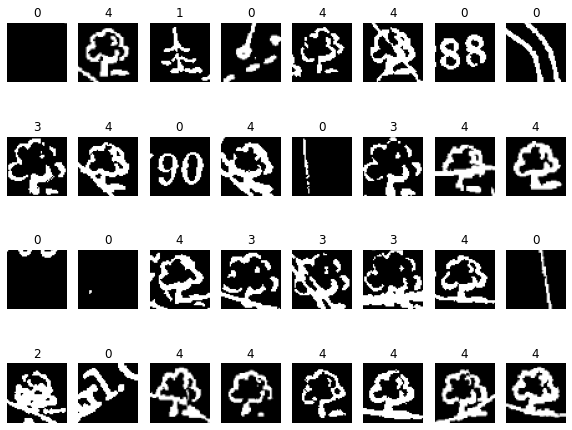

In [ ]:
# display first minibatch
images, labels = next(iter(train_loader))
figure = plt.figure(figsize=(10, 8))
cols, rows = 8, 4
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.title(labels[i].item())
    plt.axis("off")
    plt.imshow(images[i,:].squeeze(), cmap="gray")
plt.show()

As you can see here, the images are inverted so they have a black background. This is to avoid issues with convolution layers with 0 padding

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.convlayers = nn.Sequential(
          nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(6),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2), # B x 6 x 24 x 24 after maxpool

          nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(12),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2), # B x 12 x 12 x 12 after this maxpool

          nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=2, padding=0), # B x 24 x 5 x 5 after this conv
          nn.BatchNorm2d(24),
          nn.ReLU(),
        )

        self.MLP = nn.Sequential(
          nn.Dropout(0.8),
          nn.Linear(in_features=24*5*5,out_features=120),
          nn.BatchNorm1d(120),
          nn.ReLU(),
          nn.Dropout(0.6),
          nn.Linear(in_features=120,out_features=84),
          nn.BatchNorm1d(84),
          nn.ReLU(),
          nn.Linear(in_features=84,out_features=5)
        )

    def forward(self, x):
        # Input x has dimensions B x 1 x 48 x 48
        x = self.convlayers(x)
        x = x.view(x.size(0), -1)
        x = self.MLP(x)
        # Output has dimensions B x 5
        return x

model = CNN()

loss_func = nn.CrossEntropyLoss(weight=torch.FloatTensor(weights).to(device))


Above I define the loss function. I decided to use cross entropy loss. I set the parameter "weight" to a tensor containing the weights of each class (calculated by 1 / class size). This will help as the dataset is very imbalanced and setting the weight will rescale this.

In [ ]:
# check number of parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

86537


In [ ]:
import math
model = model.to(device)


optim = torch.optim.Adam(model.parameters(), lr = 0.15)

iterations_per_epoch = math.ceil(len(train_data)/batch_size)
training_losses = []
training_accuracies = []
testing_losses = []
testing_accuracies = []
for epoch in range(num_epochs):
  print('Epoch [{}/{}]'.format(epoch + 1, num_epochs))
  # initialise values for new epoch
  total_loss = 0
  correct = 0
  total = 0
  total_loss = 0
  # for batch in train loader
  for i, (inputs, labels) in enumerate(train_loader):
    inputs, labels = inputs.to(device), labels.to(device)
    output = model(inputs)
    loss = loss_func(output,labels)
    optim.zero_grad()
    loss.backward()
    optim.step()
    pred_y = torch.argmax(output, 1)
    correct += (pred_y == labels).sum()
    total += float(labels.size(0))
    total_loss += loss*images.shape[0]
    if (i+1) % 100 == 0:
       print('Iteration [{}/{}], Loss: {:.4f}'.format(i + 1, iterations_per_epoch, loss.item()))

  # calculate train accuracy for epoch
  total_loss /= len(train_data)
  training_losses.append(total_loss.item())
  training_accuracies.append(correct/total)
  print('Train accuracy : {:.4f}'.format(training_accuracies[-1]))

  # evaluation on validation set
  correct = 0
  total = 0
  model.eval()
  with torch.no_grad():
    for inputs, labels in validation_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      output = model(inputs)
      loss = loss_func(output,labels)
      pred_y = torch.argmax(output, 1)
      correct += (pred_y == labels).sum()
      total += float(labels.size(0))
      total_loss += loss * images.shape[0]
    test_accuracy = correct / total
  # calculate validation accuracy for epoch
  total_loss /= len(validation_data)
  testing_losses.append(total_loss.item())

  # Switch back to training mode for next epoch
  model.train()
  testing_accuracies.append(test_accuracy)
  print('Test accuracy  : {:.4f}'.format(test_accuracy))
  print("-" * 50)

Epoch [1/100]
Iteration [100/421], Loss: 0.9412
Iteration [200/421], Loss: 0.6602
Iteration [300/421], Loss: 1.6141
Iteration [400/421], Loss: 0.6807
Train accuracy : 0.6654
Test accuracy  : 0.8731
--------------------------------------------------
Epoch [2/100]
Iteration [100/421], Loss: 0.5738
Iteration [200/421], Loss: 1.4751
Iteration [300/421], Loss: 0.1912
Iteration [400/421], Loss: 1.3175
Train accuracy : 0.8213
Test accuracy  : 0.9495
--------------------------------------------------
Epoch [3/100]
Iteration [100/421], Loss: 0.3182
Iteration [200/421], Loss: 0.3221
Iteration [300/421], Loss: 0.2109
Iteration [400/421], Loss: 0.3959
Train accuracy : 0.8265
Test accuracy  : 0.9911
--------------------------------------------------
Epoch [4/100]
Iteration [100/421], Loss: 0.1760
Iteration [200/421], Loss: 0.2691
Iteration [300/421], Loss: 0.2955
Iteration [400/421], Loss: 0.4527
Train accuracy : 0.8621
Test accuracy  : 0.9679
--------------------------------------------------
Epoc

The CNN architecture I decided on is a modified version of a mini VGG. For the convolutions, I went for 2d convolution layers followed by batch norm, ReLU as my activation function and then max pooling. I found that 3 convolution layers performed the best. VGG does not normally use batch norm (because batch norm wasn't created till after VGG) however I decided to include it in my network as it decreases the time for training accuracy to converge and makes the network more stable. Using ReLu as the activation function is an improvement on LeNet which originally used tanh. ReLu is always preferable as it does not cause the vanishing gradient problem.

There are three fully connected layers like in VGG but with added batch norms

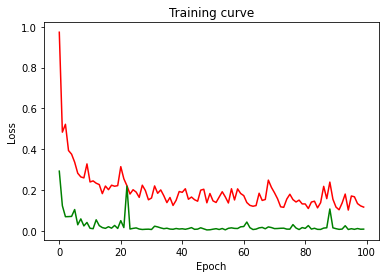

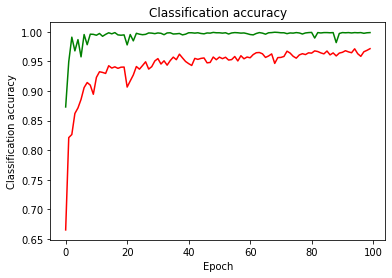

In [ ]:
from torch import Tensor
plt.title("Training curve")
plt.plot(range(len(training_losses)),training_losses,'r')
plt.plot(range(len(testing_losses)),testing_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.title("Classification accuracy")

# convert accuracies to cpu
if torch.cuda.is_available():
  training_accuracies_cpu = [x.cpu() for x in training_accuracies]
  testing_accuracies_cpu = [x.cpu() for x in testing_accuracies]
else:
  testing_accuracies_cpu = testing_accuracies
  training_accuracies_cpu = training_accuracies

plt.plot(range(len(training_accuracies)),training_accuracies_cpu,'r')
plt.plot(range(len(testing_accuracies)),testing_accuracies_cpu,'g')
plt.xlabel("Epoch")
plt.ylabel("Classification accuracy")
plt.show()

I want to visualise my predicitions on my validation set so I will plot them.

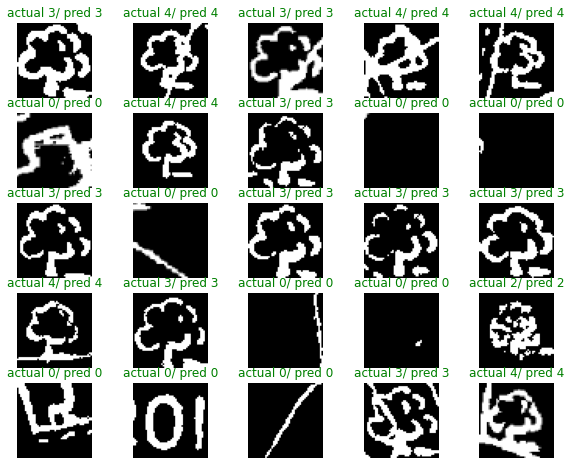

In [ ]:

images, labels = next(iter(validation_loader))
images,labels = images.to(device), labels.to(device)
output = model(images)
pred_y = torch.argmax(output, 1)

# Display first 25 images of batch with predicted labels
figure = plt.figure(figsize=(10, 8))
for i in range(25):
    figure.add_subplot(5, 5, i+1)
    # set colour for annotations to easily see if they are correct
    colour = "red"
    if labels[i] == pred_y[i]:
      colour = "green"

    plt.title("actual {}/ pred {}".format(labels[i],pred_y[i]), color=colour)
    plt.axis("off")
    plt.imshow(images[i,:].squeeze().cpu(), cmap="gray")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'weights.pkl')

# Using a GAN to generate symbols


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import random
from zipfile import ZipFile

%matplotlib inline
import matplotlib.pyplot as plt


In [ ]:
with ZipFile("symbols_dataset.zip", 'r') as zf:
    for file in zf.namelist():
        if file.startswith('class'):
            zf.extract(file, 'symbols_dataset')

In [ ]:
batch_size = 32
nz = 100
ngf = 64
ndf = 64
num_epochs = 500
lr = 0.0001
beta1 = 0.5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # make sure there is only one channel
    transforms.ToTensor(), # convert to tensor
    transforms.functional.invert, # invert image to avoid issues with 0 padding
    transforms.Normalize(0.5,0.5) # normalise to get values between -1 and 1
    ])

dataset = list(datasets.ImageFolder('symbols_dataset/', transform=transform))

sizes = {}
for i in range(1,5):
  size = len([b for (a,b) in dataset if b ==i])
  sizes[i] = (size)
  print(f"class {i} has {size} images")

# remove class 0 background class and balance dataset
new_dataset = []
for i in range(1,5):
  new_dataset += ([(a, b) for (a,b) in dataset if b == i])[:min(sizes.values())]

random.shuffle(new_dataset)
num_images = (len(new_dataset) // batch_size ) * batch_size
dataloader = torch.utils.data.DataLoader(new_dataset[:num_images], batch_size=batch_size, shuffle=True, num_workers=1)

class 1 has 181 images
class 2 has 606 images
class 3 has 3685 images
class 4 has 6356 images


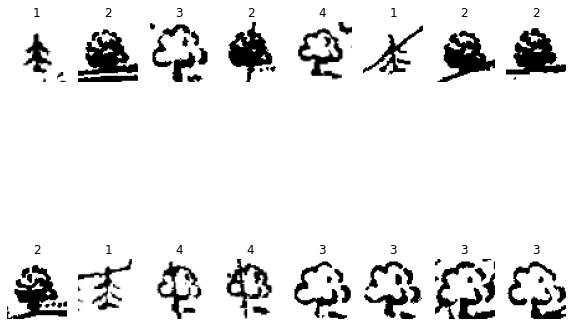

In [ ]:
# display first minibatch
images, labels = next(iter(dataloader))
figure = plt.figure(figsize=(10, 8))
cols, rows = 8, 2
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.title(labels[i].item())
    plt.axis("off")
    # invert images when showing
    plt.imshow(0.5-0.5*images[i,:].squeeze(), cmap="gray")
plt.show()

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z of size B x nz x 1 x 1
            nn.ConvTranspose2d( nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Size: B x (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Size: B x (ngf*2) x 8 x 8
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Size: B x (ngf) x 16 x 16
            nn.ConvTranspose2d( ngf, 1, 3, 3, 0, bias=False),
            # Size: B x 1 x 48 x 28
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

netG = Generator()
netG = netG.to(device)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # size = 1 x 48 x 48
            nn.Conv2d(1, ndf, 3, 3, 0, bias=False),
            nn.BatchNorm2d(ndf),
            nn.LeakyReLU(0.2, inplace=True),
            # size =(ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # size =(ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # size = (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

netD = Discriminator()
netD = netD.to(device)

In [ ]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# initialise optimizers
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

print("Training Loop:")
for epoch in range(num_epochs):
    # For each batch
    for i, (images, labels) in enumerate(dataloader, 0):

        ################### UPDATE D NETWORK################

        # Train with real batch
        netD.zero_grad()
        # Format batch
        real_images = images.to(device)
        label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_images).view(-1)
        # Calculate loss on real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        # Train with fake batch
        # generatelatent vectors
        z = torch.randn(batch_size, nz, 1, 1, device=device)
        # generate fake batch and label
        fake = netG(z)
        label.fill_(fake_label)
        # Classify batch using descriminator
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error from descriminator
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ################# UPDATE GENERATOR ########################

        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

    # Output training stats for each epoch
    print(f"[{epoch+1}/{num_epochs}] : loss D={errD.item():.3f} loss G={errG.item():.3f} D(x)={D_x:.3f} D(g)={D_G_z1:.3f} D(G(z))={D_G_z2:.3f}")

Training Loop:
[1/500] : loss D=0.341 loss G=2.349 D(x)=0.879 D(g)=0.185 D(G(z))=0.101
[2/500] : loss D=0.197 loss G=2.878 D(x)=0.930 D(g)=0.114 D(G(z))=0.063
[3/500] : loss D=0.265 loss G=2.961 D(x)=0.899 D(g)=0.122 D(G(z))=0.060
[4/500] : loss D=0.223 loss G=3.600 D(x)=0.896 D(g)=0.094 D(G(z))=0.035
[5/500] : loss D=0.156 loss G=3.785 D(x)=0.895 D(g)=0.036 D(G(z))=0.025
[6/500] : loss D=0.102 loss G=4.766 D(x)=0.931 D(g)=0.027 D(G(z))=0.010
[7/500] : loss D=0.115 loss G=4.972 D(x)=0.928 D(g)=0.035 D(G(z))=0.008
[8/500] : loss D=0.082 loss G=4.859 D(x)=0.959 D(g)=0.039 D(G(z))=0.010
[9/500] : loss D=0.187 loss G=3.811 D(x)=0.888 D(g)=0.044 D(G(z))=0.026
[10/500] : loss D=0.134 loss G=4.845 D(x)=0.918 D(g)=0.037 D(G(z))=0.012
[11/500] : loss D=0.179 loss G=4.026 D(x)=0.887 D(g)=0.044 D(G(z))=0.026
[12/500] : loss D=0.166 loss G=3.945 D(x)=0.880 D(g)=0.022 D(G(z))=0.032
[13/500] : loss D=0.120 loss G=4.677 D(x)=0.939 D(g)=0.046 D(G(z))=0.017
[14/500] : loss D=0.290 loss G=3.916 D(x)=0.8

I decided to use a classic DCGAN architecture.

For the generator is comprised of 4 convolutional-transpose layers with batch norm layers and ReLU activations. The final step is tanh which changed the output to be in the range [-1,1]. Using the batch norms standardize the previous layers activations so it has a mean of 0 and unit variance. This helps to stabilize the training process.

For the discriminator I used 4 Conv2d layers with BatchNorm2d, and LeakyReLU layers. LeakyReLu is used rather than ReLu (Like for the generator) to prevent weights being 0, causing a dying state, meaning it cannot learn. This is because LeakyRelu will let some negative values pass through, unlike ReLu. Finally, Sigmoid is used which has the range [0,1] (fake/real)

For the optimizers, I used Adam. This is better than using SGD as the learning rate can change during training according to how quickly the weights are changing.

I trained for more epochs for this as the dataset is smaller as I decided to balance it manually, resulting in less data. However I do not think this negatively affected my results.

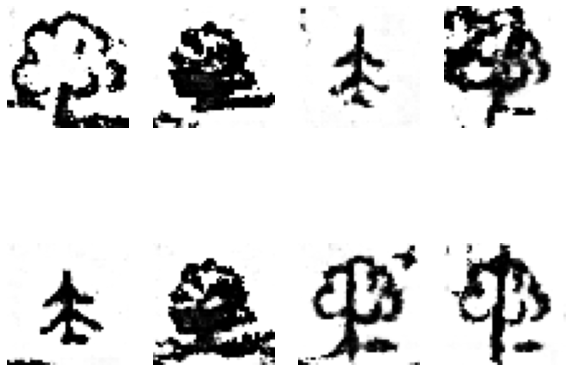

In [ ]:
# generate 8 random latent codes
z = torch.randn(8, nz, 1, 1, device=device)
images = netG(z)

# show generated images
figure = plt.figure(figsize=(10, 8))
cols, rows = 4 , 2
for i in range(cols * rows):
    figure.add_subplot(rows, cols, i+1)
    plt.axis("off")
    # invert images when showing
    plt.imshow(0.5-0.5*images[i,:].cpu().detach().squeeze(), cmap="gray")
plt.show()

Above I have generated 8 images from my GAN.

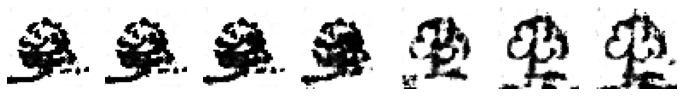

In [ ]:
nsamples = 7
z1 = torch.randn(1, nz, 1, 1, device=device)
z2 = torch.randn(1, nz, 1, 1, device=device)
z = torch.zeros(nsamples,nz,1,1,device=device)
for i in range(nsamples):
  w1 = i/(nsamples-1)
  w2 = 1-w1
  z[i,:,:,:] = w1*z1 + w2*z2
images = netG(z)

figure = plt.figure(figsize=(12, 4))
for i in range(nsamples):
    figure.add_subplot(1, nsamples, i+1)
    plt.axis("off")
    plt.imshow(0.5-0.5*images[i,:].squeeze().cpu().detach(), cmap="gray")
plt.show()


Above I have interpolated between two random tree symbol images in latent space.